In [1]:
pip install datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.3/247.3 kB 8.2 MB/s eta 0:00:00


In [2]:
import requests#產生HTTP請求的函式庫
import datetime#處理日期和時間的函式庫
import pandas as pd#資料處理和分析的函式庫
import matplotlib.pyplot as plt#繪圖函式庫

import numpy as np#處理矩陣、陣列運算的函式庫
import gc#請理電腦及編譯迄無用資源的函式庫

!pip install -q keras#安裝keras機器學習庫
import keras
from keras.models import Sequential#匯入 Sequential() 以便進行建造身經網路架構
from keras.layers import Activation, Dense#引入激勵函數以及層數
from keras.layers import LSTM#引入LSTM演算法
from keras.layers import Dropout#引入dropout 正規化

#魔法函數，這樣就不需要在繪圖設定後加上plt.show()這句話就可以直接繪圖了
%matplotlib inline


ERROR: Invalid requirement: 'keras#安裝keras機器學習庫'


In [3]:
neurons = 512                 # number of hidden units in the LSTM layer神經元數量
activation_function = 'tanh'  # activation function for LSTM and Dense layer激勵函數種類Hyperbolic Tangent
loss = 'mse'                  # loss function for calculating the gradient, in this case Mean Squared Error均方誤差(Mean square error，MSE)
optimizer= 'adam'             # optimizer for appljying gradient decent優化函數，一般而言，比SGD(雖機梯度下降)模型訓練成本較低
dropout = 0.25                # dropout ratio used after each LSTM layer to avoid overfitting每一輪以0.25的機率丟掉隨機隱藏神經元
batch_size = 128              #批量大小將決定我們一次訓練的樣本數目
epochs = 53                   #當一個完整的資料集通過了神經網路一次並且返回了一次，這個過程稱為一次epoch
window_len = 7               # is an intiger to be used as the look back window for creating a single input sample.
training_size = 0.8           # porportion比例of data to be used for training
#merge_date = '2016-01-01'     # the earliest date which we have data for both ETH and BTC or any other provided coin

In [4]:
def get_market_data(symbol, comparison_symbol, limit,aggregate, tag=True, exchange='', all_data=True):#從cryptocompare中找歷史資料
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    print(url)
    if exchange:
        url += '&e={}'.format(exchange)
    print(url)
    page = requests.get(url)
    data = page.json()['Data']#取json上的Data字典
    df = pd.DataFrame(data)#將字典轉換成pandas的陣列
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]#增加timestamp行，為每個time所對應到的當地時間
    if tag:
        df.columns = [df.columns[0]] + [tag + "_" + i for i in  df.columns[1:7]] +  [df.columns[i] for i in range(7,10)]#將資料前面加上幣種
    return df

def merge_data(a, b):#合併a,b陣列
    merged_data = pd.merge(a, b, on=['timestamp'])
    #merged_data = merged_data[merged_data['timestamp'] >= from_date]
    return merged_data

def add_volatility(data, coins=['BTC', 'ETH']):#增加一行新的資料:波動性
  """
  data: input data, pandas DataFrame
  coins: default is for 'btc and 'eth'. It could be changed as needed
  This function calculates the volatility and close_off_high of each given coin in 24 hours,
  and adds the result as new columns to the DataFrame.
  Return: DataFrame with added columns
  """
  for coin in coins:
    # calculate the daily change
    kwargs = {coin + '_change': lambda x: (x[coin + '_close'] - x[coin + '_open']) / x[coin + '_open'],#今天漲跌幅度
             coin + '_close_high': lambda x: 2*(x[coin + '_high'] - x[coin + '_close']) / (x[coin + '_high'] - x[coin + '_low']) - 1,#比較收盤價較靠近最低價還是最高價，負數代表較靠近最低價，正數則代表較靠近最高價
             coin + '_volatility': lambda x: (x[coin + '_high'] - x[coin + '_low']) / (x[coin + '_open'])}#顯示出今天市場波動大小
    data = data.assign(**kwargs)#新增新的行
  return data

def create_model_data(data):#製造資料庫
  """
  data: pandas DataFrame
  This function drops unnecessary columns and reverses the order of DataFrame based on decending dates.
  Return: pandas DataFrame
  """
  #$data = data[['timestamp']+[coin+metric for coin in ['btc_', 'eth_'] for metric in ['Close','Volume','close_off_high','volatility']]]
  data = data[['timestamp']+[coin+metric for coin in ['BTC_', 'ETH_'] for metric in ['close','volumeto']]]#只取closse、timestamp和volumeto這三行資料
  data = data.sort_values(by='timestamp')#以日期為排列順序，由早到晚
  return data

def split_data(data, training_size=0.8):#分割資料集為前0.8:0.2
  """
  data: Pandas Dataframe
  training_size: proportion of the data to be used for training
  This function splits the data into training_set and test_set based on the given training_size
  Return: train_set and test_set as pandas DataFrame
  """
  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]

def create_inputs(data, coins=['BTC', 'ETH'], window_len=window_len):#製造input資料型態，將close以及volumeto正規化介於-1~1
    #是以最早的第一筆資料為基準去正規化
    #以前前七筆資料來預測明天的價格
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coins: coin datas which will be used as the input. Default is 'btc', 'eth'
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create input array X from the given dataset and will normalize 'Close' and 'Volume' between 0 and 1
  Return: X, the input for our model as a python list which later needs to be converted to numpy array.
  """
  norm_cols = [coin + metric for coin in coins for metric in ['_close', '_volumeto']]#取輸入陣列中的close、volumeto 列
  inputs = []#初始化input陣列
  for i in range(len(data) - window_len):#從0到data的倒數第八個，跑n-7次
    temp_set = data[i:(i + window_len)].copy()#淺複製(shallow copy)資料到temp_set，一次會複製七個數
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1
  return inputs

def create_outputs(data, coin, window_len=window_len):#正規化close，使其介於-1~1之間，也就是製造標籤，對應了每七天預測出來的正確答案
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coin: the target coin in which we need to create the output labels for
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create the labels array for our training and validation and normalize it between 0 and 1
  Return: Normalized numpy array for 'Close' prices of the given coin
  """
  return (data[coin + '_close'][window_len:].values / data[coin + '_close'][:-window_len].values) - 1


def to_array(data):#將輸入轉換為numpy陣列
  """
  data: DataFrame
  This function will convert list of inputs to a numpy array
  Return: numpy array
  """
  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)


def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  """
  inputs: input data as numpy array
  output_size: number of predictions per input sample
  neurons: number of neurons/ units in the LSTM layer
  active_func: Activation function to be used in LSTM layers and Dense layer
  dropout: dropout ration, default is 0.25
  loss: loss function for calculating the gradient
  optimizer: type of optimizer to backpropagate the gradient
  This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer
  and finally a dense layer to produce the output using keras' sequential model.
  Return: Keras sequential model and model summary
  """
  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))#第一個隱藏層；input_shape:參數，表示尺寸的元組
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))#第二個隱藏層，return_sequences=True，表示返回所有hidden state值(output)
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_func))#第三個隱藏層
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))#全連接層，units:輸出維度空間
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])# 編譯: 選擇損失函數、優化方法及成效衡量方式
  model.summary()#輸出模組的訊息
  return model

In [5]:
def show_plot(data, tag):#將歷史價格資料(USD)繪製成折線圖、成交量(USD)繪製成長條圖
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})#將畫面分成高度為3:1的樣子
  ax1.set_ylabel('Closing Price ($)',fontsize=12)#設置Y軸標題
  ax2.set_ylabel('Volume ($ USD)',fontsize=12)
  ax1.plot(data.timestamp, data[tag+"_close"])#繪製第一張圖
  plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)#將X軸文字傾斜45度
  ax2.bar(data.timestamp, data[tag+"_volumeto"])#繪製第二張圖
  plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)#將X、Y軸文字都傾斜45度
  plt.setp(ax2.yaxis.get_majorticklabels(), rotation=45)
  fig.tight_layout()#自動調整介面
  plt.show()#顯示


def date_labels():
  #last_date = market_data.iloc[0, 9]#第一天的時間
  last_date = market_data.iloc[len(market_data)-1,9]
  date_list = [last_date - datetime.timedelta(days=x) for x in range(len(X_test))]#計算出陣列由最後一天到最新一天
  return[date.strftime('%m/%d/%Y') for date in date_list][::-1]#從陣列最後一項對應的當地時間


def plot_results(history, model, Y_target, coin):
  plt.figure(figsize=(25, 20))#設定圖片屬性25*20d
  #繪製收斂圖
  plt.subplot(311)#三個分割畫面之一
  plt.plot(history.epoch, history.history['loss'], )
  plt.plot(history.epoch, history.history['val_loss'])
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.title(coin + ' Model Loss')
  plt.legend(['Training', 'Test'])

  #繪製預測結果(輸入輸出皆正規化至-1~1之間
  plt.subplot(312)#三個分割畫面之二
  plt.plot(Y_target)
  plt.plot(model.predict(X_train))
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Training Set')
  plt.legend(['Actual','Predicted'])

  #繪製真實預測結果與實際資料的折線圖
  ax1 = plt.subplot(313)#三個分割畫面之三
  plt.plot(test_set[coin + '_close'][window_len:].values.tolist())#畫出原始資料圖
  plt.plot(((np.transpose(model.predict(X_test)) + 1) * test_set[coin + '_close'].values[:-window_len])[0])#畫出預測資料圖
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Test Set')
  plt.legend(['Actual','Predicted'])

  #加上日期
  date_list = date_labels()
  ax1.set_xticks([x for x in range(len(date_list))])
  for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:#每兩個資料貼上一個日期標籤
    label.set_visible(False)#隱藏坐標軸

  plt.show()

In [7]:
 market_data.iloc[len(market_data)-1,9]

NameError: name 'market_data' is not defined

In [8]:
btc_data = get_market_data("BTC", "USD", 1250, 1, "BTC")
eth_data = get_market_data("ETH", "USD", 1250, 1, "ETH")

https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=1250&aggregate=1
https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=1250&aggregate=1
https://min-api.cryptocompare.com/data/histoday?fsym=ETH&tsym=USD&limit=1250&aggregate=1
https://min-api.cryptocompare.com/data/histoday?fsym=ETH&tsym=USD&limit=1250&aggregate=1


In [9]:
btc_data.head(1725)

,time,BTC_high,BTC_low,BTC_open,BTC_volumefrom,BTC_volumeto,BTC_close,conversionType,conversionSymbol,timestamp
0,1602028800,10679.76,10554.41,10603.90,19601.45,2.082535e+08,10672.67,direct,,2020-10-07
1,1602115200,10957.42,10541.20,10672.67,39280.36,4.238078e+08,10929.40,direct,,2020-10-08
2,1602201600,11109.32,10839.30,10929.40,32665.61,3.598024e+08,11058.78,direct,,2020-10-09
3,1602288000,11485.43,11057.98,11058.78,26181.83,2.969258e+08,11301.57,direct,,2020-10-10
4,1602374400,11434.10,11284.09,11301.57,17795.07,2.021310e+08,11375.51,direct,,2020-10-11
...,...,...,...,...,...,...,...,...,...,...
1246,1709683200,67645.97,62851.27,63804.11,68031.77,4.498441e+09,66115.57,direct,,2024-03-06
1247,1709769600,68065.89,65610.94,66115.57,41800.64,2.804368e+09,66928.15,direct,,2024-03-07
1248,1709856000,70151.23,66173.73,66928.15,59361.92,4.046245e+09,68269.39,direct,,2024-03-08
1249,1709942400,68663.92,68026.81,68269.39,16947.10,1.158711e+09,68446.32,direct,,2024-03-09


In [11]:
eth_data.head()

,time,ETH_high,ETH_low,ETH_open,ETH_volumefrom,ETH_volumeto,ETH_close,conversionType,conversionSymbol,timestamp
0,1602028800,342.87,333.27,340.85,341462.64,1.156947e+08,341.91,direct,,2020-10-07
1,1602115200,353.40,334.35,341.91,295984.38,1.022197e+08,351.20,direct,,2020-10-08
2,1602201600,368.51,347.19,351.20,336130.72,1.207465e+08,365.41,direct,,2020-10-09
3,1602288000,378.52,365.20,365.41,253908.73,9.491552e+07,370.88,direct,,2020-10-10
4,1602374400,376.42,371.75,370.80,405554.05,1.518265e+08,374.37,multiply,BTC,2020-10-11


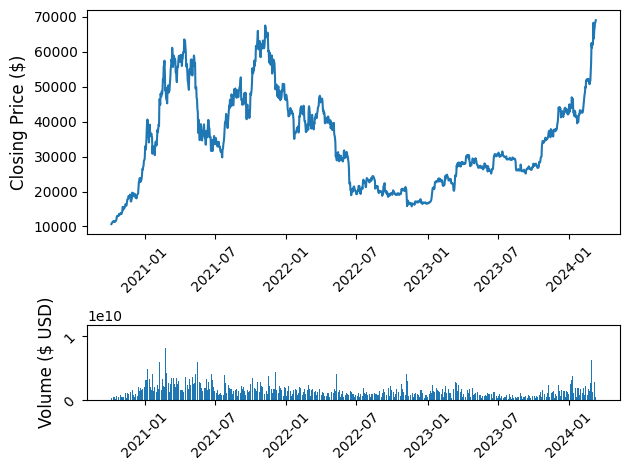

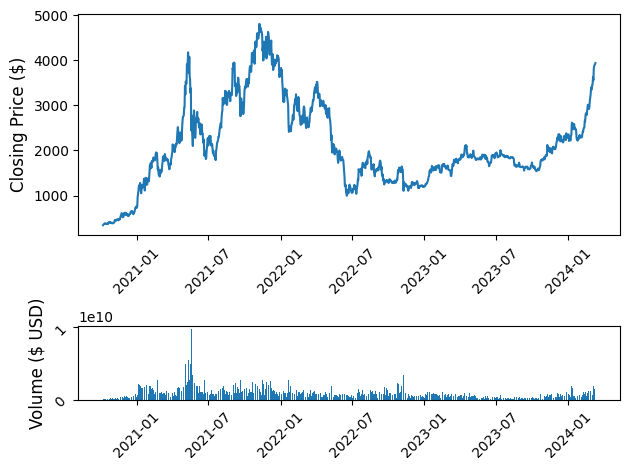

In [12]:
show_plot(btc_data,"BTC")
show_plot(eth_data,"ETH")

In [13]:
market_data = merge_data(btc_data, eth_data)
model_data = create_model_data(market_data)
train_set, test_set = split_data(model_data)

In [14]:
model_data.head()

,timestamp,BTC_close,BTC_volumeto,ETH_close,ETH_volumeto
0,2020-10-07,10672.67,2.082535e+08,341.91,1.156947e+08
1,2020-10-08,10929.40,4.238078e+08,351.20,1.022197e+08
2,2020-10-09,11058.78,3.598024e+08,365.41,1.207465e+08
3,2020-10-10,11301.57,2.969258e+08,370.88,9.491552e+07
4,2020-10-11,11375.51,2.021310e+08,374.37,1.518265e+08


In [15]:
train_set.head(1000)

,timestamp,BTC_close,BTC_volumeto,ETH_close,ETH_volumeto
0,2020-10-07,10672.67,2.082535e+08,341.91,1.156947e+08
1,2020-10-08,10929.40,4.238078e+08,351.20,1.022197e+08
2,2020-10-09,11058.78,3.598024e+08,365.41,1.207465e+08
3,2020-10-10,11301.57,2.969258e+08,370.88,9.491552e+07
4,2020-10-11,11375.51,2.021310e+08,374.37,1.518265e+08
...,...,...,...,...,...
995,2023-06-29,30447.17,6.541206e+08,1852.08,2.112100e+08
996,2023-06-30,30471.06,1.438708e+09,1933.62,6.261173e+08
997,2023-07-01,30590.76,2.216342e+08,1924.32,1.703978e+08
998,2023-07-02,30617.66,2.644390e+08,1937.46,2.595242e+08


In [16]:
test_set.head(250)

,timestamp,BTC_close,BTC_volumeto,ETH_close,ETH_volumeto
1000,2023-07-04,30774.39,4.114510e+08,1936.37,1.829212e+08
1001,2023-07-05,30503.07,4.842358e+08,1910.36,2.255395e+08
1002,2023-07-06,29907.98,9.421035e+08,1846.23,3.731117e+08
1003,2023-07-07,30349.69,5.849082e+08,1870.78,2.369984e+08
1004,2023-07-08,30294.36,1.922383e+08,1865.62,1.244730e+08
...,...,...,...,...,...
1245,2024-03-05,63804.11,8.263898e+09,3557.93,2.637640e+09
1246,2024-03-06,66115.57,4.498441e+09,3821.19,1.849427e+09
1247,2024-03-07,66928.15,2.804368e+09,3874.46,1.132012e+09
1248,2024-03-08,68269.39,4.046245e+09,3891.97,1.412263e+09


In [17]:
train_set = train_set.drop('timestamp', 1)
test_set = test_set.drop('timestamp', 1)

X_train = create_inputs(train_set)
Y_train_btc = create_outputs(train_set, coin='BTC')#BTC 在X_train 中的正確標籤
X_test = create_inputs(test_set)
Y_test_btc = create_outputs(test_set, coin='BTC')#BTC 在X_test 中的正確標籤

Y_train_eth = create_outputs(train_set, coin='ETH')#ETH 在X_train 中的正確標籤
Y_test_eth = create_outputs(test_set, coin='ETH')#ETH 在X_test 中的正確標籤

X_train, X_test = to_array(X_train), to_array(X_test)

print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_btc), np.shape(Y_test_btc))
print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_eth), np.shape(Y_test_eth))

<ipython-input-17-2b30af411fd0>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_set = train_set.drop('timestamp', 1)
<ipython-input-17-2b30af411fd0>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_set = test_set.drop('timestamp', 1)


(993, 7, 4) (244, 7, 4) (993,) (244,)
(993, 7, 4) (244, 7, 4) (993,) (244,)


In [18]:
print(X_test)

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [-8.81642171e-03  1.76897931e-01 -1.34323502e-02  2.32987012e-01]
  [-2.81536043e-02  1.28971043e+00 -4.65510207e-02  1.03973971e+00]
  ...
  [-1.55983595e-02 -5.32779621e-01 -3.65374386e-02 -3.19526615e-01]
  [-1.95909651e-02 -4.74726618e-01 -3.78440071e-02 -4.27243894e-01]
  [-1.14819498e-02  6.39545781e-01 -2.87548351e-02  3.56193555e-01]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [-1.95091838e-02  9.45547164e-01 -3.35695890e-02  6.54307536e-01]
  [-5.02834633e-03  2.07899523e-01 -2.07186080e-02  5.08067274e-02]
  ...
  [-1.08703812e-02 -5.53679747e-01 -2.47440273e-02 -5.35472718e-01]
  [-2.68923751e-03  3.93107880e-01 -1.55311041e-02  9.99252562e-02]
  [ 4.05041197e-03  1.13550391e-01 -1.66146695e-02 -2.25377121e-01]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 1.47689680e-02 -3.79146625e-01  1.32973682e-02 -3.64805694e-01]
  [ 1.29189601e-02 -7.95947831e-

In [19]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
btc_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data拿X_train練習預測Y_train_btc，則透過拿同樣的參數帶入X_test看是否可以取得正確的Y_test_btc答案
btc_history = btc_model.fit(X_train, Y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_btc), shuffle=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 512)            1058816   
                                                                 
 dropout (Dropout)           (None, 7, 512)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 512)            2099200   
                                                                 
 dropout_1 (Dropout)         (None, 7, 512)            0         
                                                                 
 lstm_2 (LSTM)               (None, 512)               2099200   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [20]:
btc_model.save('my_model_btc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 1s 108ms/step


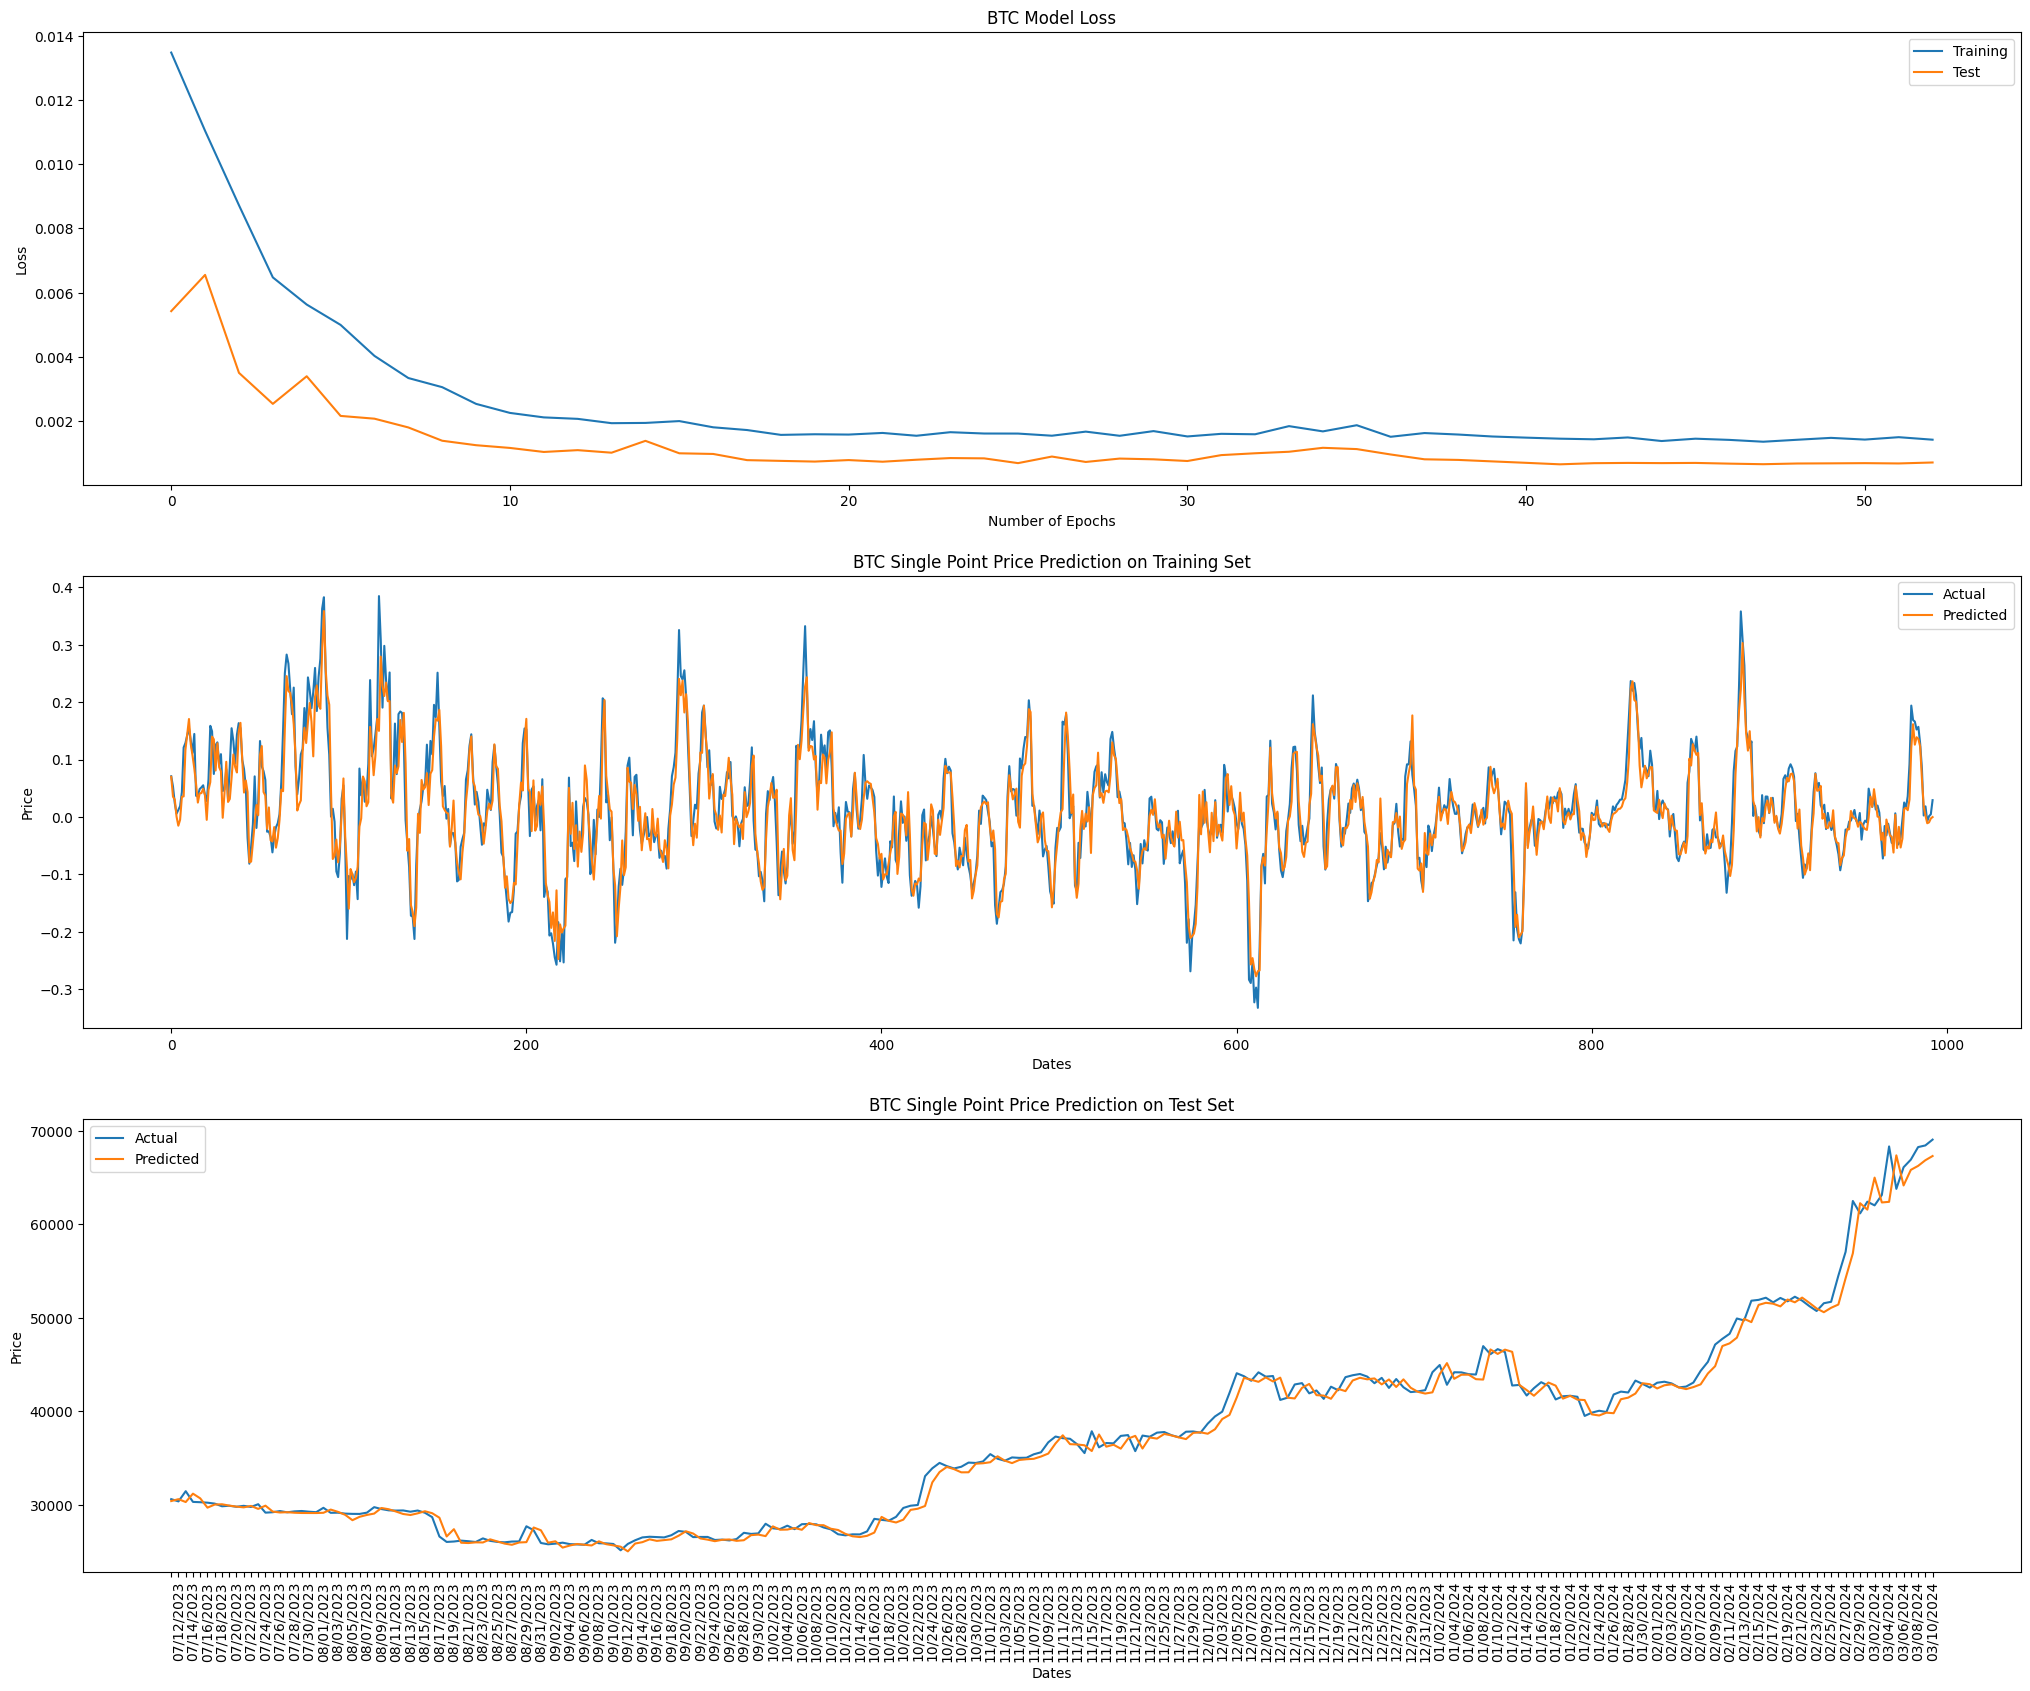

In [21]:
plot_results(btc_history, btc_model, Y_train_btc, coin='BTC')

In [22]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
eth_model = build_model(X_train, output_size=1, neurons=neurons)#其實比特幣模組於以太坊初始化都是一樣的

# train model on data拿X_train練習預測Y_train_eth，則透過拿同樣的參數帶入X_test看是否可以取得正確的Y_test_eth答案
eth_history = eth_model.fit(X_train, Y_train_eth, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_eth), shuffle=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 512)            1058816   
                                                                 
 dropout_3 (Dropout)         (None, 7, 512)            0         
                                                                 
 lstm_4 (LSTM)               (None, 7, 512)            2099200   
                                                                 
 dropout_4 (Dropout)         (None, 7, 512)            0         
                                                                 
 lstm_5 (LSTM)               (None, 512)               2099200   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [23]:
eth_model.save('my_model_eth.h5')

8/8 [==============================] - 1s 74ms/step


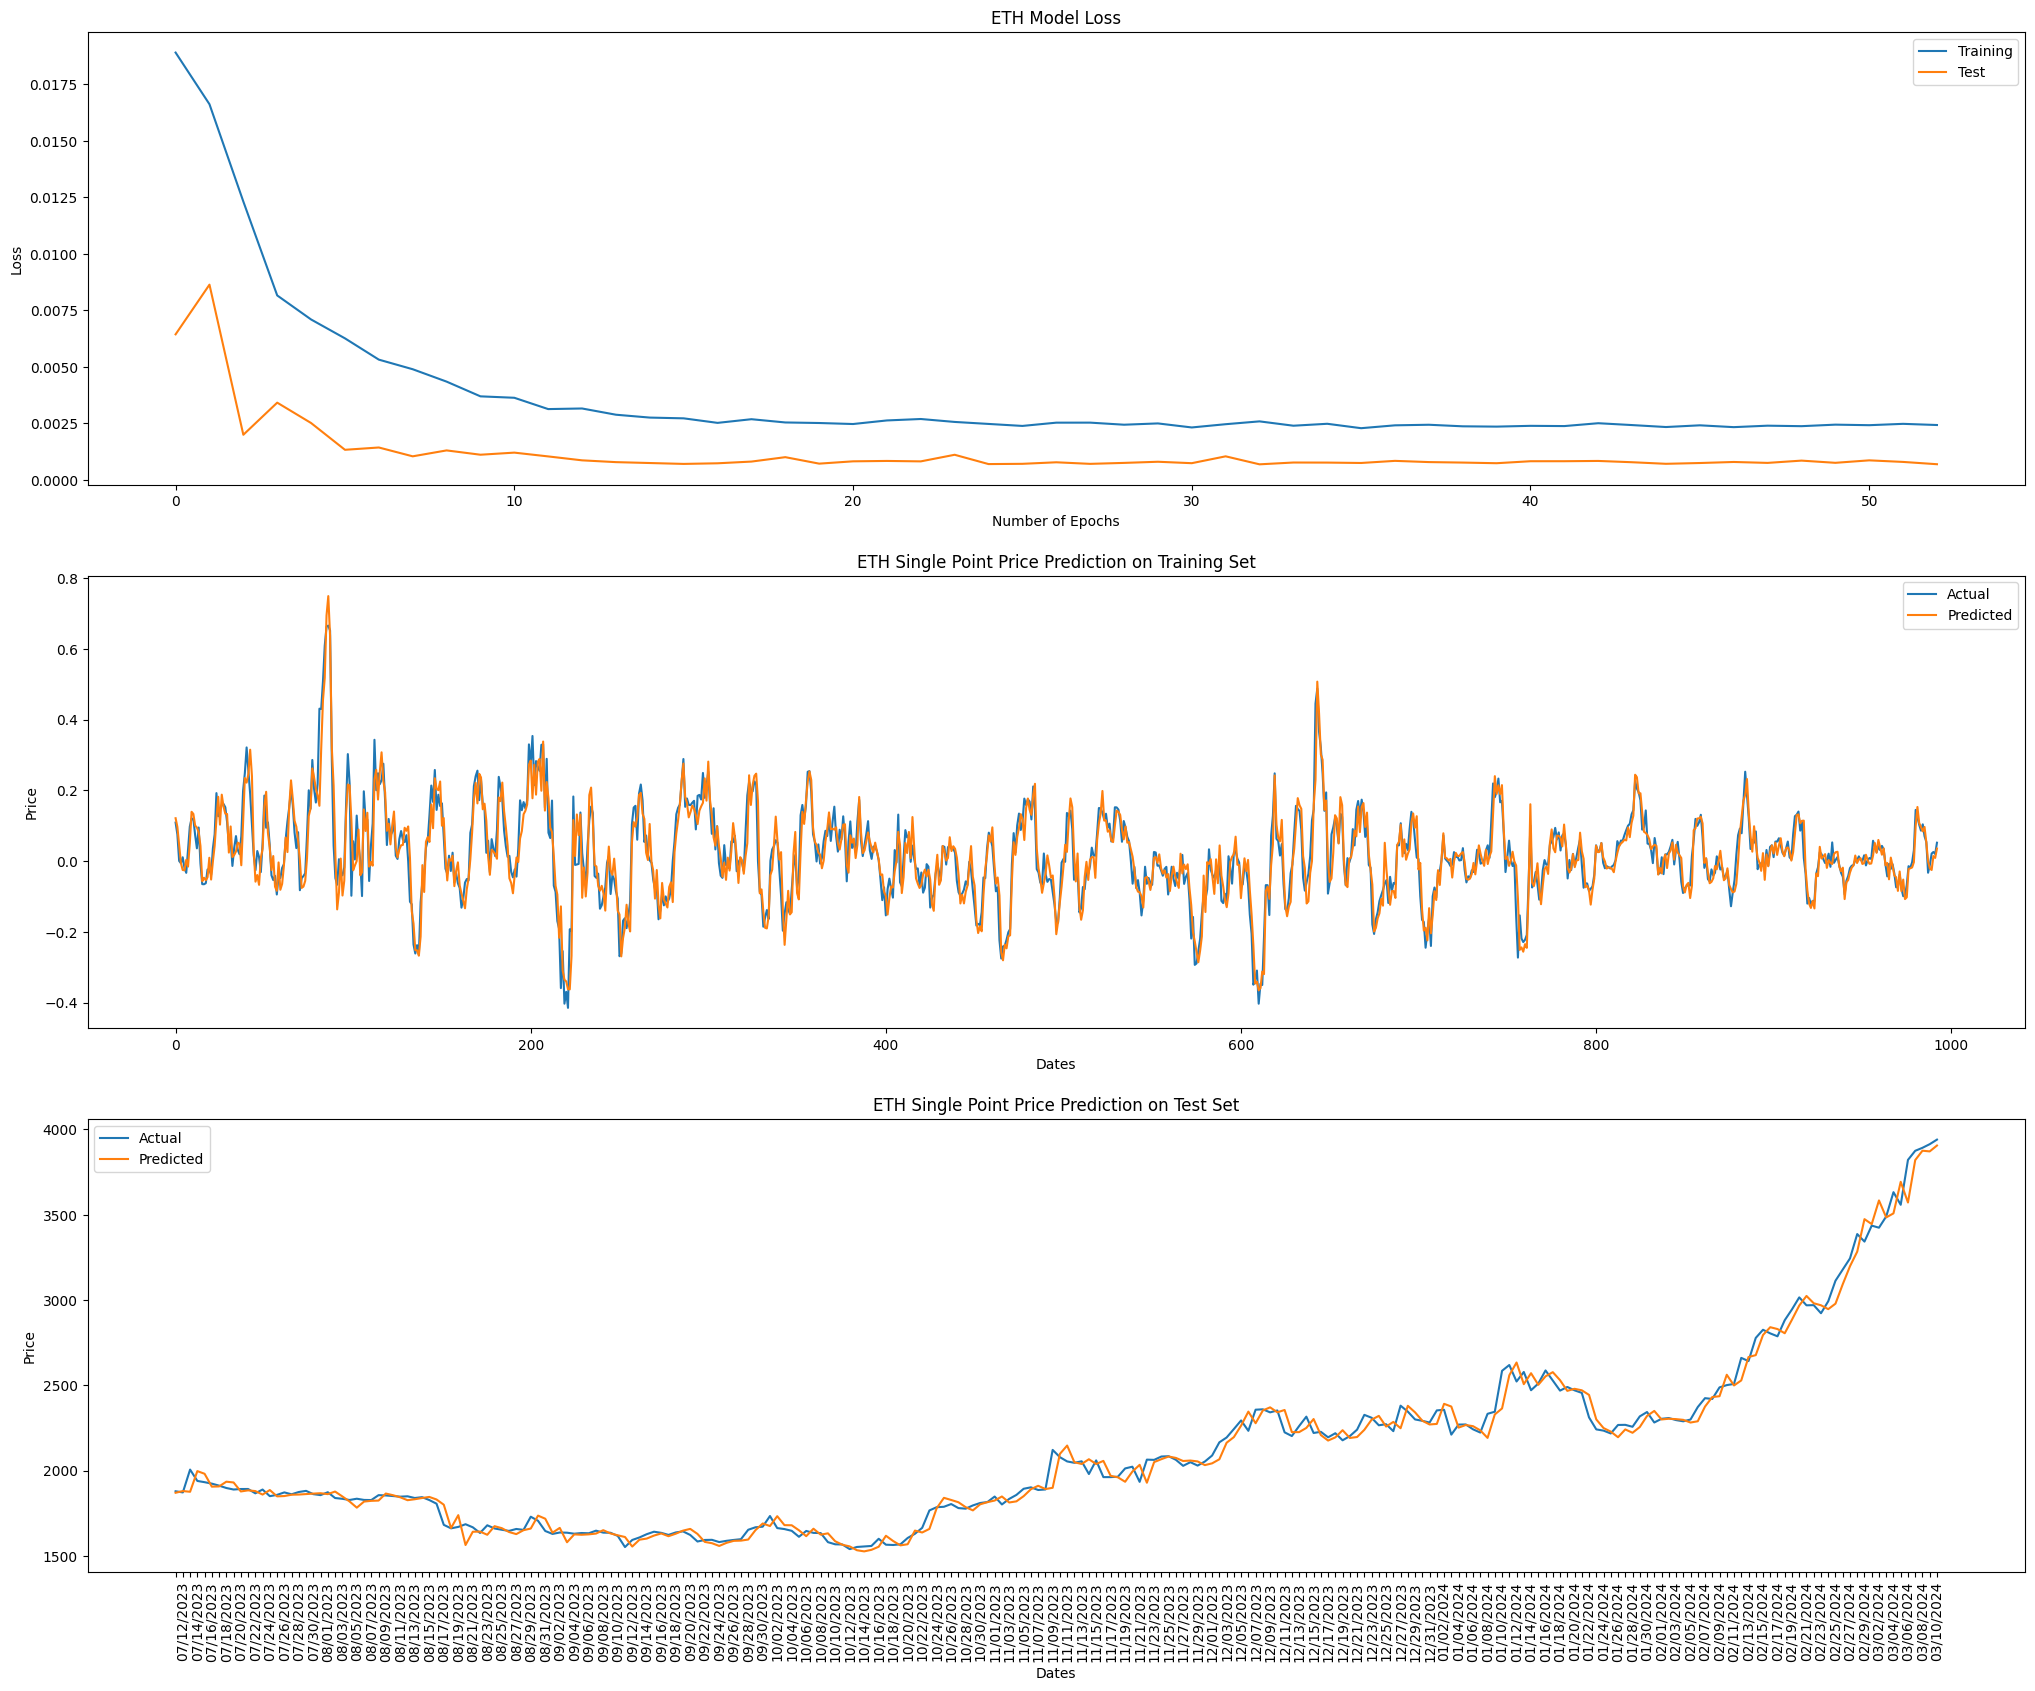

In [24]:
plot_results(eth_history, eth_model, Y_train_eth, coin='ETH')